In [10]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import ldc.io.hdf5 as h5io
from ldc.lisa.noise import get_noise_model  

In [5]:
def extract_model_info(filename):
    """
    Extracts the model name and version from the filename.
    Example:
        'resolved_Model1_0_MW_DWDs_aa2CE_NSWDs_aa2CE_vkick.h5' -> 'Model 1.0'
        'resolved_Model1_1_MW_DWDs_aa2CE_NSWDs_aa2CE_vkick.h5' -> 'Model 1.1'
    """
    # Regular expression to capture 'Model' followed by a number, an underscore, and another number
    match = re.search(r'resolved_(Model)(\d+)_(\d+)_MW', filename)
    if match:
        model_prefix = match.group(1)      # 'Model'
        model_number = match.group(2)      # e.g., '1'
        model_version = match.group(3)     # e.g., '0', '1'
        # Format as 'Model 1.0', 'Model 1.1', etc.
        formatted_model = f"{model_prefix} {model_number}.{model_version}"
        return formatted_model
    else:
        return 'Unknown'
def process_h5_file(filepath):
    """
    Processes a single .h5 file and extracts the necessary parameters.
    Returns a pandas DataFrame with the extracted data and model information.
    """
    # Extract the model from the filename
    filename = os.path.basename(filepath)
    model = extract_model_info(filename)
    
    cats, units = h5io.load_array(filepath, 'cat')
    
    data = {
        'Name': cats['Name'],
        'Frequency': cats['Frequency'],
        'Amplitude': cats['Amplitude'],
        'FrequencyDerivative': cats['FrequencyDerivative'],
        'SNR': np.sqrt(cats['snr2']),
        'Eccentricity': cats['Eccentricity'],
        'Inclination': cats['Inclination'],
        'Polarization': cats['Polarization'],
        'EclipticLatitude': cats['EclipticLatitude'],
        'EclipticLongitude': cats['EclipticLongitude'],
        'InitialPhase': cats['InitialPhase'],
        'Model': model 
    }
    
    df = pd.DataFrame(data)
    
    return df
def compile_data_from_folder(folder_path):
    """
    Compiles data from all .h5 files in the specified folder into a single DataFrame.
    """
    all_data = []
    
    # List all .h5 files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.h5') and filename.startswith('resolved_'):
            filepath = os.path.join(folder_path, filename)
            try:
                df = process_h5_file(filepath)
                all_data.append(df)
                print(f"Processed file: {filename}")
            except Exception as e:
                print(f"Error processing file {filename}: {e}")
    
    if all_data:
        # Concatenate all DataFrames
        combined_df = pd.concat(all_data, ignore_index=True)
        return combined_df
    else:
        print("No .h5 files found or no data extracted.")
        return pd.DataFrame()  # Return empty DataFrame if no data

In [6]:
resolved_folder_path = '/Users/irwin/Documents/GitHub/lisa-ml/data/resolved_binaries/'
resolved_df = compile_data_from_folder(resolved_folder_path)
resolved_df['Class'] = resolved_df['Name'].str.extract(r'MW_(DWD|NSWD)')
selected_features = ['Frequency', 'Amplitude', 'FrequencyDerivative', 'SNR', 'Eccentricity']

resolved_df = resolved_df.dropna(subset=selected_features + ['Class'])

# Encode labels: DWD=0, NSWD=1
label_encoder = LabelEncoder()
resolved_df['Class'] = label_encoder.fit_transform(resolved_df['Class'])
resolved_df['Frequency_mHz'] = resolved_df['Frequency'] * 1000
resolved_df['FrequencyDerivative_log10'] = np.log10(resolved_df['FrequencyDerivative'])
resolved_df['EclipticLatitude_sin'] = np.sin(resolved_df['EclipticLatitude'])
resolved_df['Amplitude_log10'] = np.log10(resolved_df['Amplitude'])
resolved_df['Inclination_cos'] = np.cos(resolved_df['Inclination'])

cols_to_remove = ['Frequency', 'FrequencyDerivative', 'EclipticLatitude', 'Amplitude', 'Inclination']
resolved_df.drop(columns=cols_to_remove, inplace=True)

Processed file: resolved_Model2_1_MW_DWDs_aa2CE_NSWDs_aa2CE_vkick.h5
Processed file: resolved_Model2_2_MW_DWDs_aa2CE_NSWDs_aa2CE_akick.h5
Processed file: resolved_Model3_1_MW_DWDs_agCE_NSWDs_agCE_vkick.h5
Processed file: resolved_Model3_0_MW_DWDs_agCE.h5
Processed file: resolved_Model1_1_MW_DWDs_aaCE_NSWDs_aaCE_vkick.h5
Processed file: resolved_Model1_0_MW_DWDs_aaCE.h5
Processed file: resolved_Model1_2_MW_DWDs_aaCE_NSWDs_aaCE_akick.h5
Processed file: resolved_Model2_4_MW_DWDs_aa2CE_NSWDs_aa2CE_bkick.h5
Processed file: resolved_Model1_4_MW_DWDs_aaCE_NSWDs_aaCE_bkick.h5
Processed file: resolved_Model2_3_MW_DWDs_aa2CE_NSWDs_aa2CE_hkick.h5
Processed file: resolved_Model1_3_MW_DWDs_aaCE_NSWDs_aaCE_hkick.h5


In [7]:
selected_features = [
    'Frequency_mHz', 
    'Amplitude_log10', 
    'FrequencyDerivative_log10', 
    'SNR', 
    'Eccentricity'
]

X = resolved_df[selected_features]
y = resolved_df['Class'] 

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=1
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_val)

In [8]:
# Define XGBoost classifier
xgb_clf = xgb.XGBClassifier(random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=param_grid,
                           cv=5,
                           scoring='roc_auc',
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 150],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='roc_auc', verbose=1)

In [9]:
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_pred_proba))

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.7}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26682
           1       1.00      0.71      0.83       314

    accuracy                           1.00     26996
   macro avg       1.00      0.86      0.92     26996
weighted avg       1.00      1.00      1.00     26996

ROC AUC Score: 0.9922817071266824


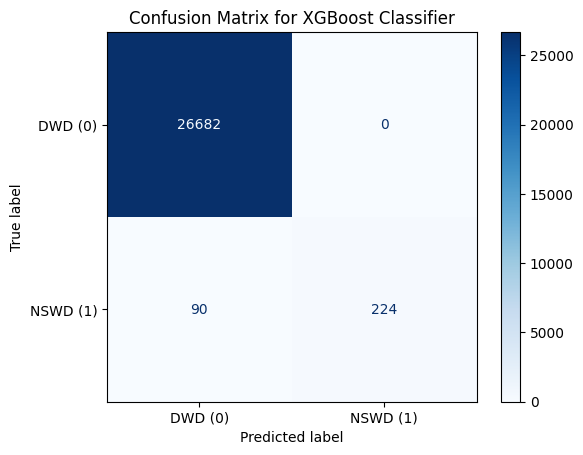

In [11]:
cm = confusion_matrix(y_val, y_pred, labels=[0, 1])  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DWD (0)', 'NSWD (1)'])

disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for XGBoost Classifier")
plt.grid(False)
plt.show()